In [13]:
import numpy as np

In [14]:
p0 = 0.9
p1 = 0.7
p2 = 0.4

# (action, k2-k1, l1, l2, m1, m2) : prob
probabilities = {
    # start maintenance
    ('M',  0, 0, 0, 0, 1) : 1,
    ('M',  0, 1, 1, 0, 1) : 1,
    ('M',  0, 2, 2, 0, 1) : 1,

    # finish maintenance
    ('N',  0, 0, 0, 1, 0) : 1,
    ('N',  0, 1, 0, 1, 0) : 1,
    ('N',  0, 2, 0, 1, 0) : 1,

    # process job
    ('J',  2, 0, 0, 0, 0) : p0,
    ('J',  0, 0, 1, 0, 0) : 1 - p0,

    ('J',  1, 1, 1, 0, 0) : p1,
    ('J',  0, 1, 2, 0, 0) : 1 - p1,

    ('J',  1, 2, 2, 0, 0) : p2,
    ('J',  0, 2, 2, 0, 0) : 1 - p2,
}

def p(a, k1, l1, m1, k2, l2, m2):
    key = (a, k2 - k1, l1, l2, m1, m2)
    if key in probabilities:
        return probabilities[key]
    else:
        return 0

def actions(k,m):
    if m == 1:
        # don't allow any other actions if we are still in maintenance
        return ['N']
    else:
        return ['M','J']

In [15]:
# number of decision epochs
N = 5

# state space
K = list(range(14+1)) # number of finished products (8 times 3 products = 24 products maximum)
L = [0,1,2] # machine state
M = [0,1] # maintenance flag
I = [(k,l,m) for k in K for l in L for m in M]

V = np.zeros((N+1, len(K), len(L), len(M)))
A = np.zeros((N+1, len(K), len(L), len(M)), dtype='str')

In [16]:
len(I)

90

In [17]:
for k in K:
    V[0,k,:,:] = k

for n in range(1,N+1):
    for k1,l1,m1 in I:
        maximum = 0
        argmax = ''
        for a in actions(k1,m1):
            S = sum(
                p(a, k1,l1,m1, k2,l2,m2) * V[n-1,k2,l2,m2]
                for k2,l2,m2 in I
            )
            if S > maximum:
                maximum = S
                argmax = a
            
        V[n,k1,l1,m1] = maximum
        A[n,k1,l1,m1] = argmax

In [18]:
V[N,0,0,0]

8.044450000000001

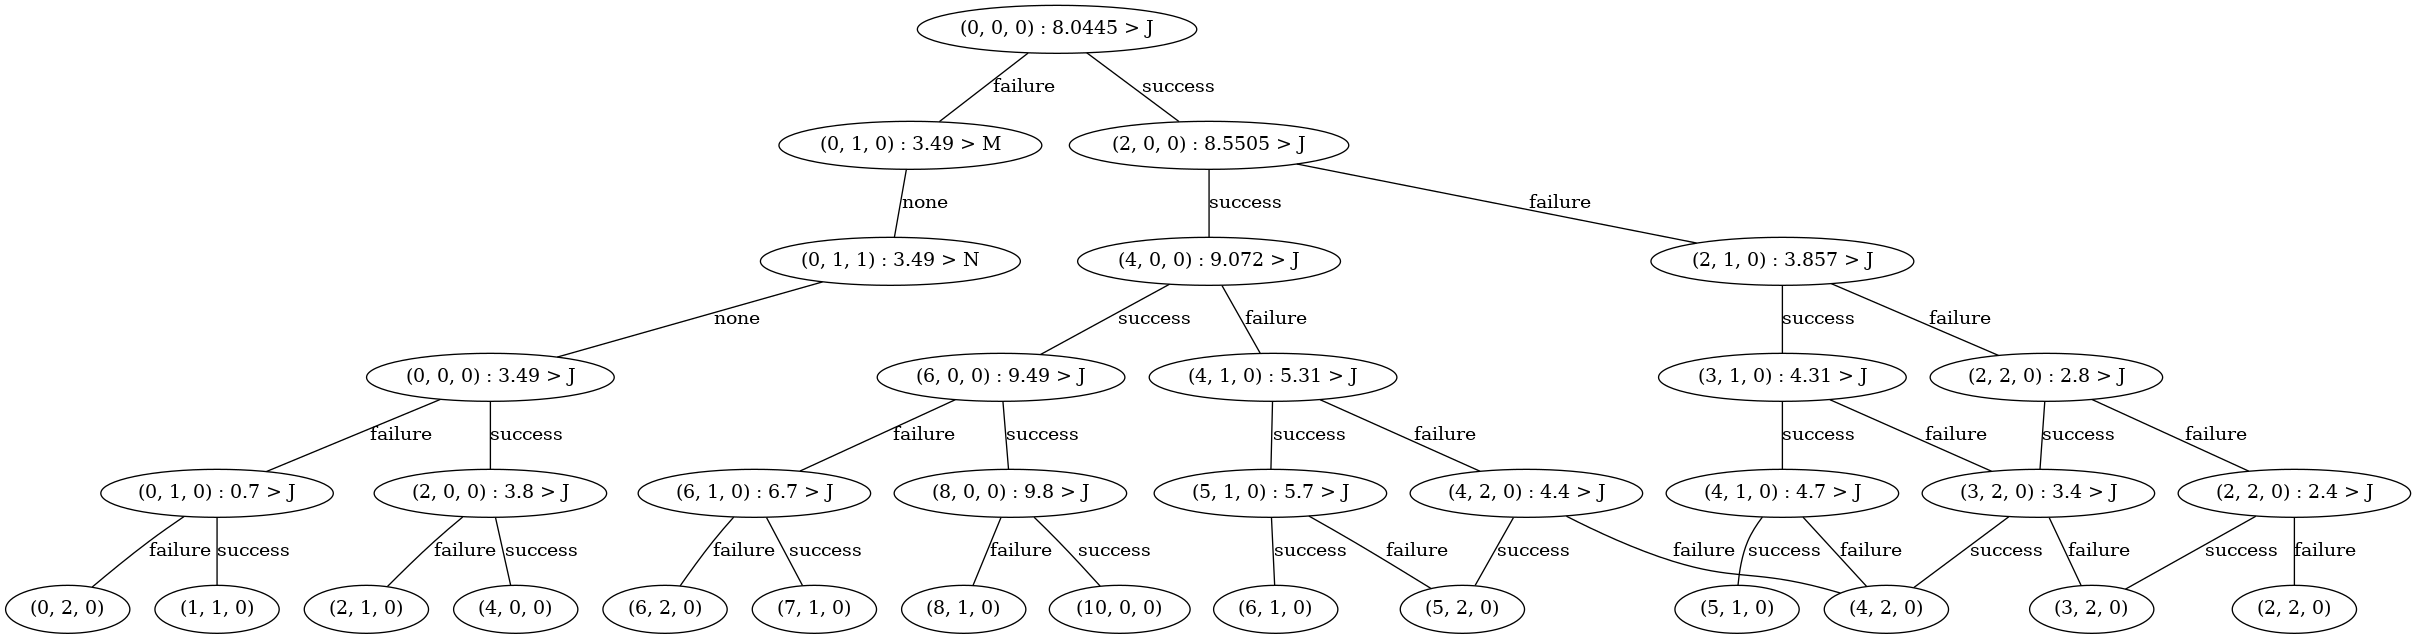

In [132]:
import pydot

graph = pydot.Dot("policy", graph_type="graph")

# list of lists containing possible states for each timestep
s = []

# initial state, value and next action
i0 = (0,0,0)
v0 = V[(N,*i0)]
a0 = A[(N,*i0)]
s.append([(i0, v0, a0)])
graph.add_node(pydot.Node(str((N, i0, a0)), label=f"{i0} : {v0:.5g} > {a0}"))

# only consider states that have a positive probability of actually occuring
for n in range(N-1,-1,-1):
    states = set()
    # iterate over all states that were reachable from the last timestep
    for i,_,a in s[-1]:
        for j in I:
            trans = p(a, *i, *j)
            if trans > 0: # only reachable states
                vn = V[(n,*j)] # current value
                an = A[(n,*j)] # optimal next action
                states.add((j, vn, an))

                state_label = (f"{j}" + (f" : {vn:.5g} > {an}" if an != '' else ''))
                graph.add_node(pydot.Node(str((n,j,an)), label=state_label))
                
                edge_label = 'none' if a != 'J' else ('success' if j[0] > i[0] else 'failure')
                graph.add_edge(pydot.Edge(str((n+1,i,a)), str((n,j,an)), label=edge_label))
    
    s.append(states)

file_name = 'policy.png'
graph.write_png(file_name)
from IPython.display import Image
Image(filename=file_name)